In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [2]:
# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [3]:
from sklearn.preprocessing import StandardScaler

class ChartDataset(Dataset):

    def __init__(self, X, y, scaler: StandardScaler):
        if scaler is not None:
            X = scaler.transform(X)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape((-1, 1))
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [4]:
import json
df = pd.read_csv('nn_dataset.csv')
print(f'loaded {len(df)} items')
# print(f'example = {all_data[0]}')

loaded 4105 items


In [5]:
from sklearn.model_selection import train_test_split

THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]
limited_data_columns = [
    'Max NPS', 'Log Length',
    *(f'N_{x}' for x in THRESHOLDS), # avg nps per bin
    *(f'T_{x}' for x in THRESHOLDS), # threshold counts
    *(f'PS_{x}' for x in THRESHOLDS), # percent stream
    # *(f'B_{x}_{b}' for x in THRESHOLDS for b in BREAK_LENGTHS)
]
X_all, y_all = df[limited_data_columns], df['Meter']
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=4, stratify=y_all
)

# train_set, test_set = torch.utils.data.random_split(all_data, [.8, .2], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(X_train)}, validation examples = {len(X_test)}")
print(X_train.shape)
print(4103 in X_train.index, 4100 in X_train.index)

train examples = 3284, validation examples = 821
(3284, 17)
True True


In [527]:
print(df.loc[df['Name'] == '_misc/[2017] XS Project Collection Full'].index)
print(df.loc[df['Name'] == '_misc/140BPM Stamina Killer'].index)

Index([4103], dtype='int64')
Index([4100], dtype='int64')


In [597]:
#X_test.loc[4103]
4103 in X_train.index

True

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(X_train.to_numpy())
# print(scaler.mean_, scaler.var_)

,copy,True
,with_mean,True
,with_std,True


In [ ]:
import monotonicnetworks as lmn

N_INPUTS = X_all.shape[-1]
class RatingMLP(nn.Module):
    def __init__(self, hidden1_size, hidden2_size):
        super(RatingMLP, self).__init__()

        self.stack = nn.Sequential(
            nn.Linear(N_INPUTS, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, 1)
        )

    def forward(self, line_tensor):
        out = self.stack(line_tensor)
        return out

class RatingMLPDropout(nn.Module):
    def __init__(self, hidden1_size, hidden2_size, dropout):
        super(RatingMLPDropout, self).__init__()

        self.stack = nn.Sequential(
            nn.Linear(N_INPUTS, hidden1_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2_size, 1)
        )

    def forward(self, line_tensor):
        out = self.stack(line_tensor)
        return out

class RatingMLPOneHidden(nn.Module):
    def __init__(self, hidden1_size):
        super(RatingMLPOneHidden, self).__init__()

        self.stack = nn.Sequential(
            nn.Linear(N_INPUTS, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, 1)
        )

    def forward(self, line_tensor):
        out = self.stack(line_tensor)
        return out

class RatingDeepMLP(nn.Module):
    def __init__(self, hidden_sizes):
        super().__init__()

        layers = [
            nn.Linear(N_INPUTS, hidden_sizes[0]),
            nn.ReLU()
        ]
        for i, h in enumerate(hidden_sizes):
            if i == len(hidden_sizes) - 1:
                layers.append(nn.Linear(h, 1))
            else:
                layers.append(nn.Linear(h, hidden_sizes[i+1]))
                layers.append(nn.ReLU())

        self.stack = nn.Sequential(*layers)

    def forward(self, line_tensor):
        out = self.stack(line_tensor)
        return out

class RatingMonotonicNN(nn.Module):
    def __init__(self, hidden1_size, hidden2_size, n_groups):
        super(RatingMonotonicNN, self).__init__()

        self.lip_nn = nn.Sequential(
            lmn.LipschitzLinear(N_INPUTS, hidden1_size, kind='one-inf'),
            lmn.GroupSort(n_groups),
            lmn.LipschitzLinear(hidden1_size, hidden2_size, kind='inf'),
            lmn.GroupSort(n_groups),
            lmn.LipschitzLinear(hidden2_size, 1, kind='inf')
        )
        self.monotonic_nn = lmn.MonotonicWrapper(self.lip_nn).to(device)

    def forward(self, line_tensor):
        out = self.monotonic_nn(line_tensor)
        return out

class RatingDeepMonotonicNN(nn.Module):
    def __init__(self, hidden_sizes, n_groups):
        super(RatingDeepMonotonicNN, self).__init__()

        layers = [
            lmn.LipschitzLinear(N_INPUTS, hidden_sizes[0], kind='one-inf'),
            lmn.GroupSort(n_groups)
        ]
        for i, h in enumerate(hidden_sizes):
            if i == len(hidden_sizes) - 1:
                layers.append(
                    lmn.LipschitzLinear(h, 1, kind='inf')
                )
            else:
                layers.append(
                    lmn.LipschitzLinear(h, hidden_sizes[i+1], kind='inf')
                )
                layers.append(lmn.GroupSort(n_groups))

        self.lip_nn = nn.Sequential(*layers)
        self.monotonic_nn = lmn.MonotonicWrapper(self.lip_nn).to(device)

    def forward(self, line_tensor):
        out = self.monotonic_nn(line_tensor)
        return out


In [46]:
import random
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy
from torch_lr_finder import LRFinder
from scipy.ndimage import convolve1d
from imbalanced_regression.utils import get_lds_kernel_window
from imbalanced_regression.loss import weighted_mse_loss

class RatingMLPClassifier:
    def __init__(
            self,
            model: nn.Module,
            optim_fn,
            X_train, y_train, X_test, y_test,
            n_epochs,
            batch_size,
            scaler=None,
            scheduler_fn=None,
            criterion=None,
            best_ckp_path='./best.pt',
            use_lds=False
        ):
        self.model = model
        self.optimizer = optim_fn(self.model.parameters())
        
        self.scaler = scaler
        # self.scheduler = ReduceLROnPlateau(
        #     self.optimizer, mode='min',
        #     factor=0.5, patience=20
        # )
        self.scheduler = None
        if scheduler_fn:
            self.scheduler = scheduler_fn(self.optimizer)
        self.criterion = criterion or nn.MSELoss()

        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self._recreate_datasets()

        self.train_losses = []
        self.test_losses = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.total_epochs = 0
        self.best_test_acc = 0
        self.best_ckp_path = best_ckp_path

        self.use_lds = use_lds
        if use_lds:
            vals, counts = np.unique_counts(y_train)
            label_dist = [0 for _ in range(np.max(vals) + 1)]
            for val, count in zip(vals, counts):
                label_dist[val] = count
            lds_kernel = get_lds_kernel_window(
                kernel='gaussian', ks=5, sigma=2
            )
            eff_label_dist = convolve1d(np.asarray(label_dist), weights=lds_kernel, mode='constant')
            weights = (1 / eff_label_dist).astype(np.float32)
            weights[0] = 0 # difficulty 0 doesn't exist
            weights = weights / np.sum(weights) * len(weights)
            self.weights = torch.tensor(weights)
    
    def _recreate_datasets(self):
        """Call this if scaler is changed, so that new dataset objects may be created"""
        rng = torch.Generator(device=device).manual_seed(2024)
        self.dataset = ChartDataset(self.X_train, self.y_train, self.scaler)
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, drop_last=True, generator=rng)
        self.test_dataset = ChartDataset(self.X_test, self.y_test, self.scaler)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True, generator=rng)

    def train(self, new_target=None):
        # note: change this if changing drop_last
        #size = len(dataset)
        size = len(self.dataset) // self.batch_size * self.batch_size
        if self.scaler:
            X_test = self.scaler.transform(X_test)
        X_test = torch.tensor(self.X_test, dtype=torch.float32)
        y_test = torch.tensor(self.y_test, dtype=torch.float32).reshape((-1, 1))
        if new_target is not None:
            self.n_epochs = new_target

        # if self.total_epochs == 0:
        #     # init bias
        #     last_layer: nn.Linear = list(self.model.stack.children())[-1]
        #     mean = np.mean(y_train)
        #     print('init bias to y_train mean: ', mean)
        #     last_layer.bias.data.fill_(mean)

        for epoch_i in range(self.total_epochs, self.n_epochs):
            if self.scheduler:
                print(f"Epoch {epoch_i+1} (last lr={self.scheduler.get_last_lr()[0]:.2e})")
            else:
                print(f"Epoch {epoch_i+1}")
            self.model.train()
            # self.model.zero_grad()
            current_loss, correct = 0, 0

            num_batches = len(self.dataloader)
            for batch_i, (X, y) in enumerate(self.dataloader):
                pred = self.model(X)
                if self.use_lds:
                    #print(y.int())
                    weights = self.weights[y.int()]
                    #print(weights)
                    loss = weighted_mse_loss(pred, y, weights)
                else:
                    loss = self.criterion(pred, y)

                current_loss += loss.item()
                correct += (torch.round(pred) == y).type(torch.float).sum().item()
                
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), 20)
                self.optimizer.step()
                # if using 1cycle, uncomment the below line
                if isinstance(self.scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    self.scheduler.step()
                self.optimizer.zero_grad()
            
            current_loss /= num_batches
            correct /= size
            self.train_losses.append(current_loss)
            self.train_accuracy.append(correct)
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {current_loss:>8f}")
            # if self.scheduler:
            #     self.scheduler.step(current_loss)
            self.total_epochs += 1
            
            self.test(X_test, y_test)
            # self.test_with_dataloader(test_dataloader)
    
    def test_with_dataloader(self, dataloader):
        test_loss, correct = 0, 0
        size = 0
        num_batches = len(dataloader)
        self.model.eval()
        with torch.no_grad():
            for X, y in dataloader:
                size += len(X)
                pred = self.model(X)
                test_loss += self.criterion(pred, y).item()
                correct += (torch.round(pred) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        self.test_losses.append(test_loss)
        self.test_accuracy.append(correct)
        print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
        # save best model
        if correct > self.best_test_acc:
            print(f'Saving best model at {self.best_ckp_path}')
            self.best_test_acc = correct
            self.save_ckp(self.best_ckp_path)
    
    def test(self, X_test: torch.Tensor, y_test: torch.Tensor):
        test_loss, correct = 0, 0
        self.model.eval()
        with torch.no_grad():
            preds = self.model(X_test)
            test_loss = self.criterion(preds, y_test).item()
            correct = (torch.round(preds) == y_test).type(torch.float).mean().item()
        self.test_losses.append(test_loss)
        self.test_accuracy.append(correct)
        print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
        # save best model
        if correct > self.best_test_acc:
            print(f'Saving best model at {self.best_ckp_path}')
            self.best_test_acc = correct
            self.save_ckp(self.best_ckp_path)

    def predict(self, X_test):
        if self.scaler:
            X_test = self.scaler.transform(X_test)
        self.model.eval() #set to eval mode
        with torch.no_grad(): # do not record the gradients during eval phase
            y = self.model(torch.tensor(X_test, dtype=torch.float32))
        return y
    
    def save_ckp(self, path):
        ckp = {
            'model': self.model.state_dict(),
            'n_epochs': self.total_epochs,
            'best_test_acc': self.best_test_acc,
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict() if self.scheduler else None,
            'train_losses': self.train_losses,
            'test_losses': self.test_losses,
            'train_accuracy': self.train_accuracy,
            'test_accuracy': self.test_accuracy,
            'scaler': self.scaler
        }
        torch.save(ckp, path)
    
    def load_ckp(self, path):
        with torch.serialization.safe_globals([
            numpy._core.multiarray._reconstruct,
            numpy.dtype,
            numpy.dtypes.Int64DType,
            numpy.dtypes.Float64DType,
            numpy._core.multiarray.scalar,
            numpy.ndarray,
            StandardScaler,
        ]):
            ckp = torch.load(path)
        self.model.load_state_dict(ckp['model'])
        self.optimizer.load_state_dict(ckp['optimizer'])
        # self.scheduler = ReduceLROnPlateau(
        #     self.optimizer, mode='min',
        #     factor=0.5, patience=20
        # )
        if 'scheduler' in ckp and ckp['scheduler']:
            self.scheduler.load_state_dict(ckp['scheduler'])
        self.best_test_acc = ckp['best_test_acc']
        self.total_epochs = ckp['n_epochs']
        self.train_losses = ckp['train_losses']
        self.test_losses = ckp['test_losses']
        self.train_accuracy = ckp['train_accuracy']
        self.test_accuracy = ckp['test_accuracy']
        self.scaler = ckp['scaler']
        self._recreate_datasets()

    def lr_find(self, **kwargs):
        lr_finder = LRFinder(self.model, self.optimizer, self.criterion, device="cuda")
        lr_finder.range_test(self.dataloader, **kwargs)
        lr_finder.plot() # to inspect the loss-learning rate graph
        lr_finder.reset() # to reset the model and optimizer to their initial state
        return lr_finder

In [897]:
from scipy.ndimage import convolve1d
from imbalanced_regression.utils import get_lds_kernel_window

vals, counts = np.unique_counts(y_train)
label_dist = [0 for _ in range(0, np.max(vals) + 1)]
for val, count in zip(vals, counts):
    label_dist[val] = count
lds_kernel_window = get_lds_kernel_window(
    kernel='gaussian', ks=5, sigma=2
)
print(counts)
print(label_dist)
eff_label_dist = convolve1d(np.asarray(counts), weights=lds_kernel_window, mode='constant')
weights = (1 / eff_label_dist).astype(np.float32)
weights[0] = 0 # difficulty 0 doesn't exist
weights = weights / np.sum(weights) * len(weights)
print(eff_label_dist)
print(eff_label_dist.shape, counts.shape)
print(weights)

[128  30  83  68  86  67 101 138 174 159 190 227 166 135 121 103  94 102
  84  82  74  73  70  67  71  72  62  58  42  46  34  38  45  40  56  42
  18  13   6   7   5   5   2]
[0, np.int64(128), np.int64(30), np.int64(83), np.int64(68), np.int64(86), np.int64(67), np.int64(101), np.int64(138), np.int64(174), np.int64(159), np.int64(190), np.int64(227), np.int64(166), np.int64(135), np.int64(121), np.int64(103), np.int64(94), np.int64(102), np.int64(84), np.int64(82), np.int64(74), np.int64(73), np.int64(70), np.int64(67), np.int64(71), np.int64(72), np.int64(62), np.int64(58), np.int64(42), np.int64(46), np.int64(34), np.int64(38), np.int64(45), np.int64(40), np.int64(56), np.int64(42), np.int64(18), np.int64(13), np.int64(6), np.int64(7), np.int64(5), np.int64(5), np.int64(2)]
[227 287 359 311 371 420 518 592 704 816 846 816 775 689 569 509 463 429
 402 381 352 337 326 324 315 305 281 257 222 200 188 186 196 204 187 157
 123  77  44  32  23  17  11]
(43,) (43,)
[ 0.          0.3991169

In [80]:
classifier = RatingMLPClassifier(
    RatingDeepMonotonicNN([512, 256, 256, 32, 32], 16),
    lambda p: torch.optim.Adam(p, lr=1e-1),
    X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(),
    1000, 64,
    scaler=None,
    # scheduler_fn=lambda optim: torch.optim.lr_scheduler.OneCycleLR(
    #     optim, max_lr=2.5, steps_per_epoch=len(X_train)//64, epochs=1000
    # ),
    criterion=nn.MSELoss(),
    best_ckp_path='checkpoints/irtest/model4_bester.pt',
    use_lds=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-01


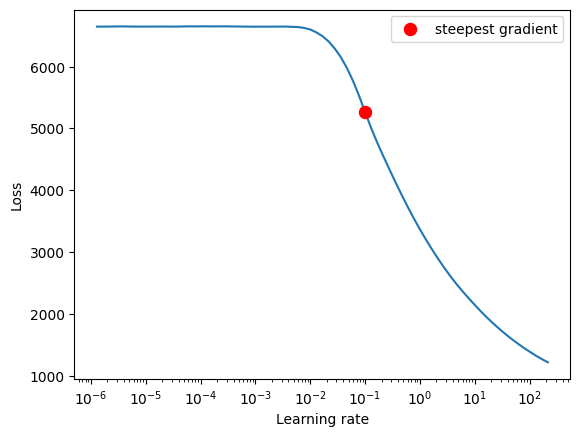

In [42]:
lr_finder = classifier.lr_find(
    val_loader=classifier.test_dataloader,
    start_lr=1e-7, end_lr=10000, num_iter=100
)

In [89]:
torch.serialization.get_unsafe_globals_in_checkpoint(classifier.best_ckp_path)

['numpy._core.multiarray._reconstruct',
 'sklearn.preprocessing._data.StandardScaler',
 'numpy.dtype',
 'numpy._core.multiarray.scalar',
 'numpy.ndarray']

In [95]:
classifier.load_ckp('checkpoints/irtest/model4_bester.pt')
print(classifier.best_test_acc, classifier.total_epochs)

0.7125456929206848 3777


In [82]:
classifier.train(4000)

Epoch 1001
Train Error: Accuracy: 61.0%, Avg loss: 0.126759
Test Error: Accuracy: 62.0%, Avg loss: 0.337113
Epoch 1002
Train Error: Accuracy: 65.6%, Avg loss: 0.104200
Test Error: Accuracy: 66.0%, Avg loss: 0.319575
Epoch 1003
Train Error: Accuracy: 66.0%, Avg loss: 0.099383
Test Error: Accuracy: 62.1%, Avg loss: 0.331800
Epoch 1004
Train Error: Accuracy: 64.9%, Avg loss: 0.104381
Test Error: Accuracy: 67.0%, Avg loss: 0.321108
Epoch 1005
Train Error: Accuracy: 63.3%, Avg loss: 0.109798
Test Error: Accuracy: 66.5%, Avg loss: 0.330410
Epoch 1006
Train Error: Accuracy: 65.1%, Avg loss: 0.105549
Test Error: Accuracy: 57.9%, Avg loss: 0.375981
Epoch 1007
Train Error: Accuracy: 67.3%, Avg loss: 0.097527
Test Error: Accuracy: 65.4%, Avg loss: 0.315806
Epoch 1008
Train Error: Accuracy: 66.6%, Avg loss: 0.097159
Test Error: Accuracy: 67.7%, Avg loss: 0.309732
Epoch 1009
Train Error: Accuracy: 60.0%, Avg loss: 0.132540
Test Error: Accuracy: 66.5%, Avg loss: 0.305491
Epoch 1010
Train Error: Accu

In [94]:
#torch.save(classifier.model.state_dict(), 'checkpoints/npslentest/model4.pt')
classifier.save_ckp('checkpoints/irtest/model5_4000.pt')

In [83]:
classifier.best_test_acc

0.7125456929206848

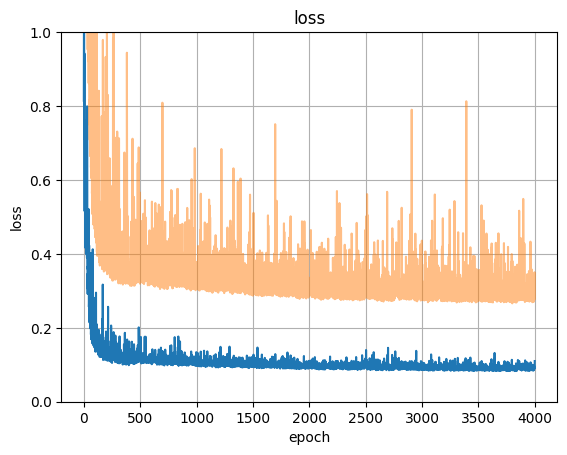

In [84]:
# Data for plotting
t = np.arange(0.0, len(classifier.train_losses), 1)
s = classifier.train_losses

fig, ax = plt.subplots()
ax.plot(t, s)

t = np.arange(0.0, len(classifier.test_losses), 1)
s = [x for x in classifier.test_losses]
ax.plot(t, s, alpha=0.5)

ax.set(xlabel='epoch', ylabel='loss',
       title='loss')
ax.set_ylim([0, 1])
ax.grid()
#fig.text(0.5, -0.1, '''Train Error: Accuracy: 22.2%, Avg loss: 3.625307''', wrap=True, horizontalalignment='center', fontsize=12)

#fig.savefig("test.png")
plt.show()

correct: 0.7125456760048721 / 821
mae: 0.40020410442468457 / 821


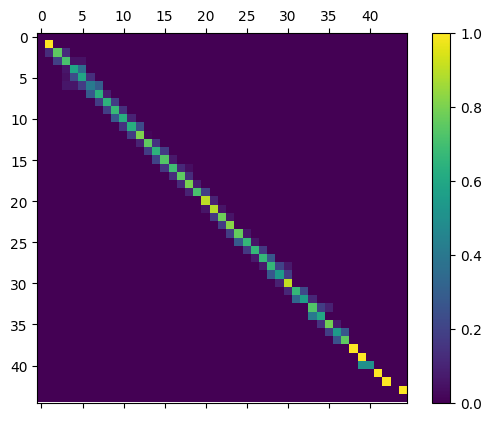

In [99]:
def display_confusion(X, y):
    width = 43-1+3
    confusion = torch.zeros(width, width)

    preds = classifier.predict(X.to_numpy())
    ys = y

    correct_count = 0
    cum_err = 0
    for pred, true_meter in zip(preds, ys):
        pred = pred.item()
        guess_meter = round(pred)
        guess_meter = max(0, min(44, guess_meter))

        cum_err += abs(pred - true_meter)
        
        if true_meter == guess_meter:
            correct_count += 1
        true_meter = max(0, min(44, true_meter))
        confusion[int(true_meter)][int(guess_meter)] += 1
    
    correct_count = (preds.cpu().numpy().squeeze().round() == y).sum()
    print(f"correct: {correct_count / len(ys)} / {len(ys)}")
    print(f"mae: {cum_err / len(ys)} / {len(ys)}")

    # Normalize by dividing every row by its sum
    for i in range(width):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    # ax.set_xticks(np.arange(width))
    # ax.set_yticks(np.arange(width))
    #ax.tick_params(axis='both', labelsize=5)
    #ax.tick_params(axis='x', labelrotation=90)

    # Force label at every tick
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

display_confusion(X_test, y_test)

In [29]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh import palettes

output_notebook()

Loading BokehJS ...

In [86]:
from bokeh.models.tickers import BasicTicker
def bokeh_display(X, y, names_df=None, palette=palettes.Turbo256):
    if names_df is None:
        names_df = df
    preds = classifier.predict(X.to_numpy()).cpu().numpy()
    correct_count = 0
    cum_err = 0
    for pred, true_meter in zip(preds, y):
        guess_meter = round(pred[0])
        cum_err += abs(pred - true_meter)        
        if true_meter == guess_meter:
            correct_count += 1
    print(f"correct: {correct_count / len(y)} / {len(y)}")
    print(f"mae: {cum_err / len(y)} / {len(y)}")

    disp_df = pd.DataFrame(index=y.index)
    disp_df['y'] = preds
    disp_df['x'] = y
    disp_df.set_index
    disp_df = disp_df.merge(names_df[['Name', 'Meter']], left_index=True, right_index=True)

    datasource = ColumnDataSource(disp_df)
    color_mapping = LinearColorMapper(
        palette=palette
    )

    plot_figure = figure(
        width=500,
        height=500,
        tools=('pan, wheel_zoom, reset')
    )

    hvr = HoverTool(tooltips="""
    <div>
        <div>
            <span style='font-size: 12px; color: #224499'>[@Meter]</span>
            <span style='font-size: 12px; color: #994422'>[@y]</span>
            <span style='font-size: 12px'>@Name</span>
        </div>
    </div>
    """)
    plot_figure.add_tools(hvr)

    scatter = plot_figure.scatter(
        'x',
        'y',
        source=datasource,
        color=dict(field='Meter', transform=color_mapping),
        line_alpha=0,
        fill_alpha=0.5,
        size=8
    )
    hvr.renderers = [scatter]
    line_vals = np.arange(min(y), max(y)+1)
    plot_figure.line(x=line_vals, y=line_vals)
    plot_figure.ygrid.ticker = BasicTicker(min_interval=1, max_interval=1)
    show(plot_figure)

bokeh_display(X_train, y_train, palette=palettes.Turbo256*2)

correct: 0.7128501827040195 / 3284
mae: [0.39312017] / 3284


In [88]:
import math
from fractions import Fraction

def get_block_repr(bpm, measures):
    THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
    BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]

    nps = bpm * 4 / 60
    measure_len = 60 / bpm * 4
    max_nps = math.ceil(nps)
    max_nps_lower = max_nps - 1
    length_secs = measure_len * measures
    length = length_secs * 2

    prop_higher = nps % 1 if nps < max_nps else 1
    prop_lower = 1 - prop_higher
    lower_bin_i = -1
    for thresh in THRESHOLDS:
        if max_nps_lower > thresh * max_nps:
            lower_bin_i += 1
        else:
            break
    
    avg_nps_per_bin = [(t+0.1) * max_nps for t in THRESHOLDS]
    nps_vals_are_in_same_bin = lower_bin_i == len(THRESHOLDS) - 1 or nps == max_nps
    if nps_vals_are_in_same_bin:
        avg_nps_per_bin[-1] = nps
    else:
        avg_nps_per_bin[-1] = max_nps
        if lower_bin_i > -1:
            avg_nps_per_bin[lower_bin_i] = max_nps_lower
    
    threshold_counts = [length for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        for i in range(lower_bin_i+1, len(THRESHOLDS)):
            threshold_counts[i] = length * prop_higher
    
    density_per_bin = [1 for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        for i in range(lower_bin_i+1, len(THRESHOLDS)):
            threshold_counts[i] = prop_higher    

    # longest continuous block of NPS >= threshold
    # allowing for different lengths of break
    longest_blocks = [[length for _ in BREAK_LENGTHS] for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        #print(nps, lower_bin_i, prop_higher, prop_lower)
        ratio_higher_to_lower = prop_higher / prop_lower
        if ratio_higher_to_lower > 1:
            block_len = math.ceil(ratio_higher_to_lower)
            break_len = 1
        else:
            block_len = 1
            break_len = math.ceil(1 / ratio_higher_to_lower)
        for thresh_i in range(lower_bin_i+1, len(THRESHOLDS)):
            for break_i, max_break_len in enumerate(BREAK_LENGTHS):
                if break_len > max_break_len:
                    longest_blocks[thresh_i][break_i] = block_len

    return [
        max_nps,
        math.log2(length+1),
        # avg_nps_per_bin,
        # threshold_counts,
        # density_per_bin,
        # longest_blocks
        *avg_nps_per_bin,
        *(math.log2(x+1) for x in threshold_counts),
        *density_per_bin
        #*(math.log2(x+1) for row in longest_blocks for x in row)
    ]

In [ ]:
get_block_repr(130, 32)

In [89]:
inp = get_block_repr(510, 64)
#print(inp)
classifier.predict([inp])

tensor([[44.4833]], device='cuda:0')

In [90]:
inp = [get_block_repr(bpm, 32) for bpm in range(10, 520, 10)]
#print(inp)
out = classifier.predict(inp)
for i, r in enumerate(out):
    print(10+i*10, r+0.5)

10 tensor([-5.6884], device='cuda:0')
20 tensor([2.0295], device='cuda:0')
30 tensor([4.1585], device='cuda:0')
40 tensor([4.1958], device='cuda:0')
50 tensor([5.6764], device='cuda:0')
60 tensor([7.0232], device='cuda:0')
70 tensor([6.9369], device='cuda:0')
80 tensor([9.0337], device='cuda:0')
90 tensor([9.4878], device='cuda:0')
100 tensor([10.2999], device='cuda:0')
110 tensor([10.9243], device='cuda:0')
120 tensor([11.2604], device='cuda:0')
130 tensor([11.6511], device='cuda:0')
140 tensor([12.0151], device='cuda:0')
150 tensor([12.2734], device='cuda:0')
160 tensor([12.7210], device='cuda:0')
170 tensor([13.1932], device='cuda:0')
180 tensor([13.5950], device='cuda:0')
190 tensor([14.3070], device='cuda:0')
200 tensor([14.9857], device='cuda:0')
210 tensor([15.6178], device='cuda:0')
220 tensor([16.5868], device='cuda:0')
230 tensor([17.7768], device='cuda:0')
240 tensor([18.7053], device='cuda:0')
250 tensor([19.9347], device='cuda:0')
260 tensor([21.1602], device='cuda:0')
270

In [92]:
RESOLUTION = 200
STREAM_BOUNDS = (0, 16)
BPM_BOUNDS = (10, 600)
x, y = np.meshgrid(
    np.linspace(BPM_BOUNDS[0], BPM_BOUNDS[1], RESOLUTION),
    np.linspace(STREAM_BOUNDS[0], STREAM_BOUNDS[1], RESOLUTION)
)
inp = np.reshape(np.dstack((x, y)), (-1, 2))
inp = [get_block_repr(item[0], 2**item[1]) for item in inp]
image = classifier.predict(inp)
image = image.cpu().numpy().reshape((RESOLUTION, RESOLUTION))
# out = classifier.model(torch.tensor(inp, dtype=torch.float32))
# out = out.detach().numpy().reshape((RESOLUTION, RESOLUTION)).round()

-9.95388 70.59364


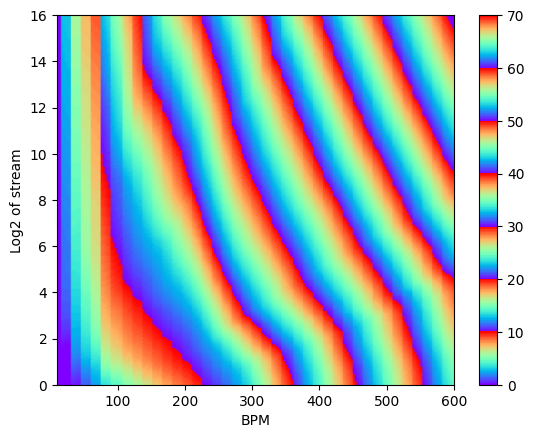

In [93]:
import matplotlib
from matplotlib.colors import ListedColormap, Normalize

vmin = np.min(image)
vmax = np.max(image)
print(vmin, vmax)
norm = Normalize(vmin=vmin-0.5, vmax=vmax+0.5)
norm = Normalize(vmin=0, vmax=70)
cmap = matplotlib.colormaps['rainbow']
cmap = ListedColormap(cmap(np.linspace(0, 7, int(500)) % 1))
# cmap = matplotlib.colormaps['viridis']

fig = plt.figure()
ax = fig.add_subplot()

#ax.view_init(elev=90, azim=-90, roll=0)
ax.set_xlabel('BPM')
ax.set_ylabel('Log2 of stream')
#ax.set_zlabel('Density')
pos = ax.imshow(image, origin='lower', cmap=cmap, alpha=1, extent=(*BPM_BOUNDS, *STREAM_BOUNDS),
          aspect='auto', norm=norm)
fig.colorbar(pos)
plt.show()

In [72]:
from analysis.analyzer import SongAnalyzer
from analysis.hash import get_hash
import math
import itertools
import simfile

THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]
def extract_features(seq: list[int]):
    max_nps = max(seq)
    length = len(seq)
    cum_nps_per_bin = [0 for _ in THRESHOLDS]
    count_per_bin = [0 for _ in THRESHOLDS]
    # num of samples where NPS > the threshold (fraction of max NPS)
    threshold_counts = [0 for _ in THRESHOLDS]
    segs_per_thresh = [[] for _ in THRESHOLDS]
    for nps in seq:
        for thresh_i, thresh in enumerate(THRESHOLDS):
            segs = segs_per_thresh[thresh_i]
            if nps > thresh * max_nps:
                threshold_counts[thresh_i] += 1
                if not segs or segs[-1] < 0: # if prev was break, start a new seg
                    segs.append(0)
                segs[-1] += 1
            else:
                if not segs or segs[-1] > 0: # if prev was a block, start a new seg
                    segs.append(0)
                segs[-1] -= 1
        bin_i = -1
        for thresh in THRESHOLDS:
            if nps > thresh * max_nps:
                bin_i += 1
            else:
                break
        if bin_i > -1:
            cum_nps_per_bin[bin_i] += nps
            count_per_bin[bin_i] += 1
    
    default_avg_nps = [x * max_nps for x in (0.1, 0.3, 0.5, 0.7, 0.9)]
    avg_nps_per_bin = [
        (cum_nps / count if count > 0 else default)
        for cum_nps, count, default in zip(cum_nps_per_bin, count_per_bin, default_avg_nps)
    ]

    density_per_bin = []
    for segs, count in zip(segs_per_thresh, threshold_counts):
        total_len = length
        if segs:
            if segs[0] < 0:
                total_len += segs[0]
            if len(segs) > 1 and segs[-1] < 0:
                total_len += segs[-1]
            density_per_bin.append(count / total_len)
        else:
            density_per_bin.append(0)

    return [
        max_nps,
        math.log2(length+1),
        # avg_nps_per_bin,
        # threshold_counts,
        # density_per_bin
        # longest_blocks
        *avg_nps_per_bin,
        *(math.log2(x+1) for x in threshold_counts),
        *density_per_bin
    ]

data_columns = [
    'Max NPS', 'Log Length',
    *(f'N_{x}' for x in THRESHOLDS), # avg nps per bin
    *(f'T_{x}' for x in THRESHOLDS), # threshold counts
    *(f'PS_{x}' for x in THRESHOLDS), # percent stream
    # *(f'B_{x}_{b}' for x in THRESHOLDS for b in BREAK_LENGTHS)
]
columns = [
    'Name', 'Hash', 'Meter',
    *data_columns
]

def handle_song(song, pack_name, seen_hashes):
    data = []
    song_analyzer = SongAnalyzer(song)
    song_str = f'{pack_name}/{song.title or ""}'

    for chart_analyzer in song_analyzer.chart_analyzers.values():
        chart = chart_analyzer.chart
        if (chart.stepstype or '').lower() != 'dance-single':
            continue
        diff = (chart.difficulty or '').lower()
        title = song_str
        if diff != 'challenge':
            title += f' ({diff})'

        chart_hash = get_hash(song, chart_analyzer.chart)
        if chart_hash in seen_hashes:
            print(f'skipping {title} (dupe hash)')
            continue
        seen_hashes.add(chart_hash)
        print(f'analyzing {title}')
        try:
            meter = int(chart_analyzer.chart.meter)
        except ValueError:
            print(song.title, ': invalid meter')
            continue

        seq1 = chart_analyzer.get_notes_per_second_list(-0.5)
        seq2 = chart_analyzer.get_notes_per_second_list(0)
        seq = [
            val for pair in itertools.zip_longest(seq1, seq2, fillvalue=0)
            for val in pair
        ]

        try:
            start = next(i for i,v in enumerate(seq) if v > 0)
            end = next(i for i,v in enumerate(reversed(seq)) if v > 0)
        except StopIteration:
            print(title, ': empty?')
            continue

        seq = seq[start:len(seq)-end]
        # print(seq)
        features = extract_features(seq)
        # print(features)

        data.append((
            title,
            chart_hash,
            meter,
            *features
        ))
    return data

In [96]:
from simfile.dir import SimfilePack
import glob

glob_path = r"C:\Users\Lenovo\AppData\Roaming\ITGmania\Songs\Egg Carton*"
real_test_data = []
seen_hashes = set()
# for path in glob.glob(glob_path):
#      pack = SimfilePack(path)
#      for song in pack.simfiles(strict=False):
#           real_test_data.extend(handle_song(song, pack.name, seen_hashes))

song = simfile.open(r'pack_archive\651b1724-688f-4197-9cb6-7206f80f0dc2_24_hours_of_100_bpm_stream.sm')
real_test_data.extend(handle_song(song, '_misc', seen_hashes))

test_df = pd.DataFrame(real_test_data, columns=columns)
X_real, y_real = test_df[limited_data_columns], test_df['Meter']

analyzing _misc/24 hours of 100 bpm stream (beginner)
analyzing _misc/24 hours of 100 bpm stream (easy)
analyzing _misc/24 hours of 100 bpm stream (medium)
analyzing _misc/24 hours of 100 bpm stream (hard)
analyzing _misc/24 hours of 100 bpm stream


In [97]:
long_stuff_df = test_df
long_stuff_df

,Name,Hash,Meter,Max NPS,Log Length,N_0,N_0.2,N_0.4,N_0.6,N_0.8,T_0,T_0.2,T_0.4,T_0.6,T_0.8,PS_0,PS_0.2,PS_0.4,PS_0.6,PS_0.8
0,_misc/24 hours of 100 bpm stream (beginner),b9db1c5d8023eb40907a71fe5a944cf99ba3a879,1,1,17.398710,0.1,0.3,0.5,0.7,1.000000,16.135729,16.135729,16.135729,16.135729,16.135729,0.416679,0.416679,0.416679,0.416679,0.416679
1,_misc/24 hours of 100 bpm stream (easy),d7ea212a84659dbe7d1329677b559e7eab150166,1,1,17.398727,0.1,0.3,0.5,0.7,1.000000,17.135719,17.135719,17.135719,17.135719,17.135719,0.833348,0.833348,0.833348,0.833348,0.833348
2,_misc/24 hours of 100 bpm stream (medium),d0b9104caaaef463dfe04ca77513fe02e9601d2f,1,2,17.398752,0.2,0.6,1.0,1.4,2.000000,17.398752,17.398752,17.398752,16.813794,16.813794,1.000000,1.000000,1.000000,0.666674,0.666674
3,_misc/24 hours of 100 bpm stream (hard),465f2216a8c13cc4ce18e8dac103d79c4d1d5dad,1,4,17.398760,0.4,1.0,2.0,3.0,4.000000,17.398760,17.398760,17.398752,17.398744,15.813806,1.000000,1.000000,1.000000,1.000000,0.333337
4,_misc/24 hours of 100 bpm stream,961629f4a1fc35c863ed378d82a29d3a8e5c1d2c,1,7,17.398760,0.7,2.1,3.5,4.9,6.666665,17.398760,17.398760,17.398760,17.398744,17.398744,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
bokeh_display(X_real, y_real, test_df)

correct: 0.0 / 5
mae: [6.41118] / 5


1.9607843137254901
[1.         1.34117647 1.49960784 1.4172549  1.26431373 1.47764706
 1.47764706 1.26431373 1.4172549  1.49960784 1.34117647 1.34117647
 1.47764706 0.18117647 0.        ]


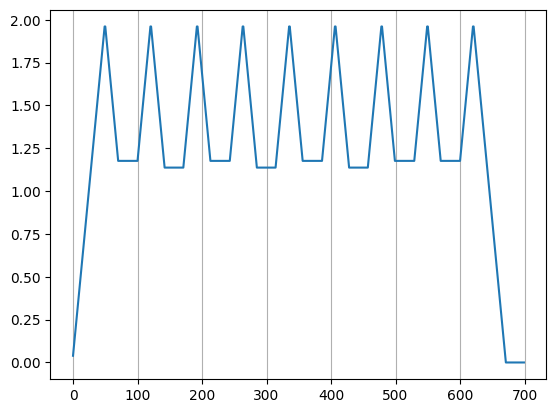

In [861]:
# 100 samples = 1 sec
test_nps = 1.4
spacing = 100 / test_nps
length_secs = 6
window_len = 100
points_spacing = 50
idxs = (np.arange(0, length_secs * test_nps) * spacing).round().astype(int)
a = np.zeros(round(length_secs * 100) + 1)
a[idxs] = 1
r = np.arange(window_len)
#v = np.ones((100,))
v = (window_len + 1 - np.abs(r - r[::-1]))
v = v / np.sum(v) * 100

conv = np.convolve(a, v)
plt.plot(conv)
plt.grid(axis='x')
print(np.max(conv))
n_points = len(conv) // points_spacing + 1
print(np.pad(
    conv, [0, n_points*points_spacing - len(conv)], constant_values=0
).reshape(n_points, points_spacing) @ np.ones(points_spacing) / points_spacing)

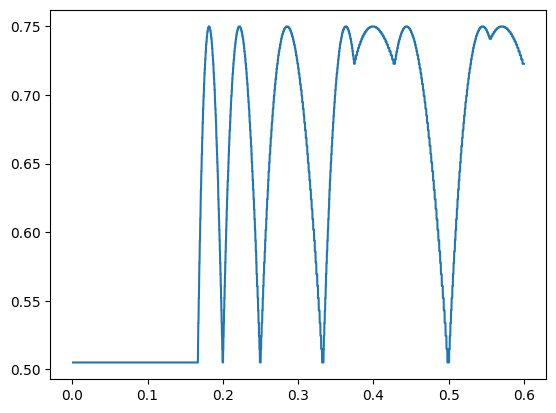

In [879]:
def calc_max_sample(test_nps):
    spacing = 100 / test_nps
    length_secs = 6
    window_len = 199
    points_spacing = 100
    idxs = (np.arange(0, length_secs * test_nps) * spacing).round().astype(int)
    a = np.zeros(round(length_secs * 100) + 1)
    a[idxs] = 1
    r = np.arange(window_len)
    #v = np.ones((100,))
    v = (window_len + 1 - np.abs(r - r[::-1]))
    v = v / np.sum(v) * 100

    conv = np.convolve(a, v)
    n_points = len(conv) // points_spacing + 1
    samples = np.pad(
        conv, [0, n_points*points_spacing - len(conv)], constant_values=0
    ).reshape(n_points, points_spacing) @ np.ones(points_spacing) / points_spacing
    return np.max(samples)

xs = np.arange(0.001, 0.6, 0.0002)
plt.plot(xs, [calc_max_sample(x) for x in xs])